#### Remapping BSP into Eulerian coordinates for ECCO outputs

In [1]:
from WM_Methods import Remapping
import xarray as xr
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load MTM result

yr_init=1992 # Applies to T and S and BSP data

MTM_result = xr.open_mfdataset('../Outputs/64ITFcons15Sv_transports.nc')

Basins = MTM_result.Basins
tree_depth=int(math.log2(MTM_result.tree_depth))

month_init_early=(MTM_result.init_early-yr_init)*12
month_init_late=(MTM_result.init_late-yr_init)*12
Early_period = (np.array([month_init_early,month_init_early+MTM_result.dyrs*12]))
Late_period = (np.array([month_init_late,month_init_late+MTM_result.dyrs*12]))


In [3]:
## LOAD T and S data from a gridded observations

chunks = {'time': 1, 'k': 25}

filename = 'folders_ECCO.txt'
with open(filename) as f:
    mylist = f.read().splitlines() 

Tdata = xr.open_mfdataset(mylist[14],chunks = chunks).isel(time=slice(Early_period[0],Early_period[1]))
Sdata = xr.open_mfdataset(mylist[15],chunks = chunks).isel(time=slice(Early_period[0],Early_period[1]))

T = Tdata.THETA*(~Tdata.maskC-1)/(~Tdata.maskC-1)
S = Sdata.SALT*(~Sdata.maskC-1)/(~Sdata.maskC-1)

## Load BSP data

path=('../tree_depth_'+str(tree_depth)+'_BSP_ECCO/BSP_ECCO_monthly*')

ECCO_data = xr.open_mfdataset(path)
partitions=ECCO_data.Partitions_hist.isel(Time=slice(Early_period[0],Early_period[1]), Basin=0)


OSError: no files to open

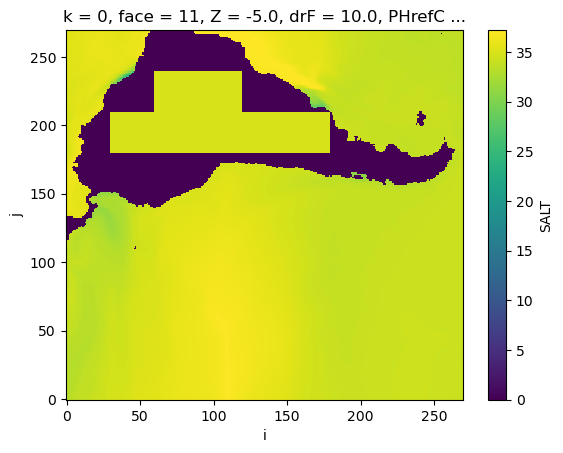

In [22]:
Sdata.SALT.isel(time=0,k=0,face=11).plot()

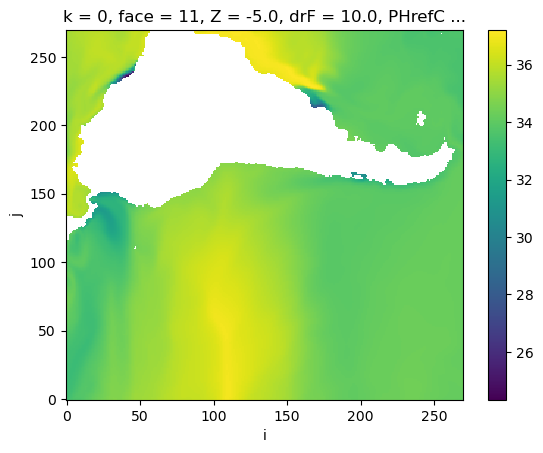

In [23]:
S.isel(time=0,k=0,face=11).plot()

In [12]:
partitions.isel(Time=0).values

array([[21.58580399, 34.41358566, -1.99537277,  2.43272781],
       [34.41358566, 34.54647827, -2.34807658,  2.43272972],
       [27.19478798, 34.47271729,  2.43273592,  2.86252761],
       [34.47271729, 34.54647827,  2.43272972,  2.86252308],
       [34.54647827, 34.58753586, -1.88711059,  2.41232276],
       [34.58753586, 34.61076355, -1.85717225,  2.41232061],
       [34.54647827, 34.58757019,  2.41232443,  2.86252713],
       [34.58757019, 34.61075974,  2.41232967,  2.86252618],
       [29.32489014, 34.37915802,  2.86252761,  3.36468077],
       [34.37915802, 34.49565125,  2.86252999,  3.36466742],
       [28.38022995, 34.33391571,  3.36468148,  3.96628833],
       [34.33391953, 34.49565125,  3.36468124,  3.96629524],
       [34.49565125, 34.5792923 ,  2.86254263,  3.31125832],
       [34.5792923 , 34.61075974,  2.86252975,  3.31125736],
       [34.49565125, 34.56692505,  3.31125927,  3.96629405],
       [34.56692505, 34.61075592,  3.31125855,  3.96623707],
       [34.61076355, 34.

Text(0.5, 1.0, 'Temperature')

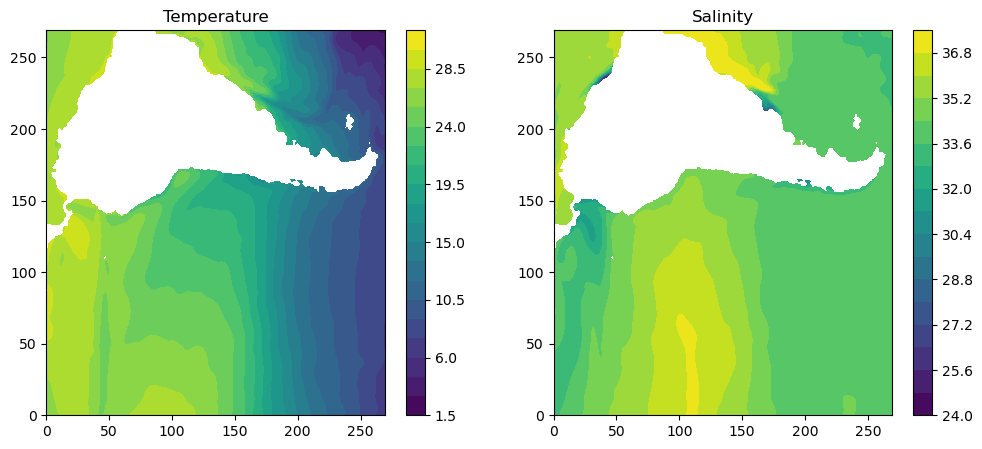

In [10]:
## Plot surface T and S

tile=11

fig, (ax0, ax1) = plt.subplots(1,2, figsize = (12,5))

c=ax1.contourf(S.isel(face = tile, k=0, time=0),20)
fig.colorbar(c, ax=ax1)
ax1.set_title('Salinity')
                               
c=ax0.contourf(T.isel(face = tile, k=0, time=0),20)
fig.colorbar(c, ax=ax0)
ax0.set_title('Temperature')                               

In [ ]:
## Remapping



chunks2={'time': 1, 'tree_depth': 1, 'k': 25}

ti = 0
T = T.isel(time = slice(ti*12,ti*12+12))
S = S.isel(time = slice(ti*12,ti*12+12))
partitions = partitions.isel(Time = slice(ti*12,ti*12+12))

from tqdm import tqdm
da_fuzz = xr.zeros_like(S).expand_dims({'tree_depth':2**tree_depth}).assign_coords({'tree_depth':np.arange(0,2**tree_depth)})
for i in tqdm(range(T.shape[0])):
    for j in tqdm((range(2**tree_depth))):
        da_fuzz[j,i] = xr.where((S.isel(time=i)>partitions[i,j,0])&\
                                (T.isel(time=i)>partitions[i,j,2])&\
                                (S.isel(time=i)<=partitions[i,j,1])&\
                                (T.isel(time=i)<=partitions[i,j,3]),\
                                1, 0)

In [8]:
da_fuzz.chunk(chunks = chunks2)

<xarray.DataArray (tree_depth: 32, time: 12, k: 50, face: 13, j: 270, i: 270)>
dask.array<rechunk-merge, shape=(32, 12, 50, 13, 270, 270), dtype=float64, chunksize=(1, 1, 25, 13, 270, 270), chunktype=numpy.ndarray>
Coordinates: (12/21)
  * i           (i) int32 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j           (j) int32 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * k           (k) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * face        (face) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC          (face, j, i) float32 dask.array<chunksize=(13, 270, 270), meta=np.ndarray>
    YC          (face, j, i) float32 dask.array<chunksize=(13, 270, 270), meta=np.ndarray>
    ...          ...
    rhoRef      (k) float32 dask.array<chunksize=(25,), meta=np.ndarray>
    rLowC       (face, j, i) float32 dask.array<chunksize=(13, 270, 270), meta=np.ndarray>
    rSurfC      (face, j, i) float32 dask.array<chunksize=(13, 270, 270), meta=np.ndarray>
    iter        (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
  * time        (time) timedelta64[ns] 1127 days 1155 days ... 1461 days
  * tree_depth  (tree_depth) int32 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31

In [ ]:
## Save da_fuzz to netcdf

outputpath = ('E:/MTM/Remapping_mask/tree_depth_'+str(tree_depth)+'/Remapping_mask_ECCO')

MTM_remapping=xr.Dataset()
MTM_remapping['da_fuzz'] = da_fuzz.chunk(chunks = chunks2)
MTM_remapping['partitions'] = partitions

MTM_remapping.to_netcdf(outputpath + '.' + str(ti) + '.nc')
